In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm

import healpy as hp
import numpy as np
import h5py
import os

from msfm.utils.io import read_yaml

In this notebook, the four patches/survey footprints are defined. This is based on the analogous notebook for KiDS1000 in the handover repo, where additional functions (more kinds of rotations) that are not needed here can be found.

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

nside = conf["analysis"]["nside"]
npix = conf["analysis"]["npix"]

### load Metacal catalog

In [3]:
# data given by Dominik
data_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

# consider all tomographic bins
tomo = 0

# J2000 angles in degrees
alpha = h5py.File(os.path.join(data_dir, f'ALPHAWIN_J2000_tomo={tomo}.h5'))['ALPHAWIN_J2000'][:]
delta = h5py.File(os.path.join(data_dir, f'DELTAWIN_J2000_tomo={tomo}.h5'))['DELTAWIN_J2000'][:]

# angles like in healpy in radian
theta = -np.deg2rad(delta) + np.pi/2
phi = np.deg2rad(alpha)

# derived pixel ids, shape (num_galaxies,)
pix = hp.ang2pix(nside=nside, theta=theta, phi=phi)

# vector positions of the galaxies, shape (num_galaxies, 3)
vec = hp.ang2vec(theta=theta, phi=phi)

### original footprint

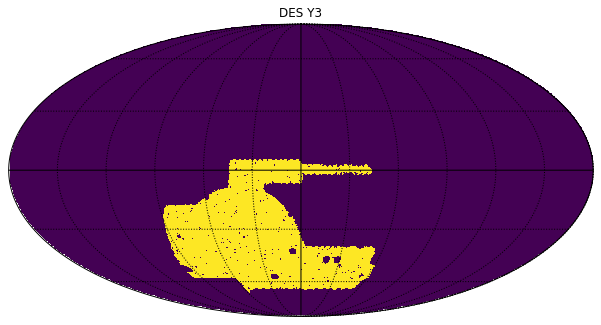

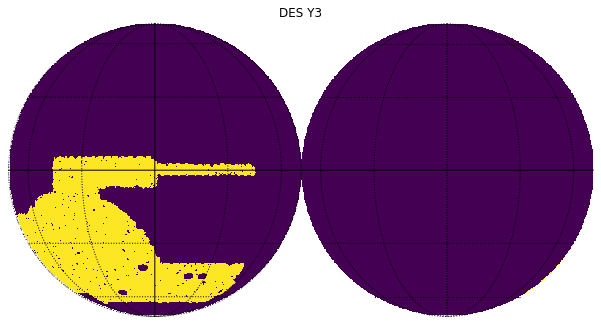

In [4]:
des_y3_mask = np.zeros(npix)
des_y3_mask[pix] = 1
hp.mollview(des_y3_mask, cbar=False, title="DES Y3")
hp.graticule()
hp.orthview(des_y3_mask, cbar=False, title="DES Y3")
hp.graticule()

### rotated footprint

In [5]:
# these are the standard rotation matrices

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

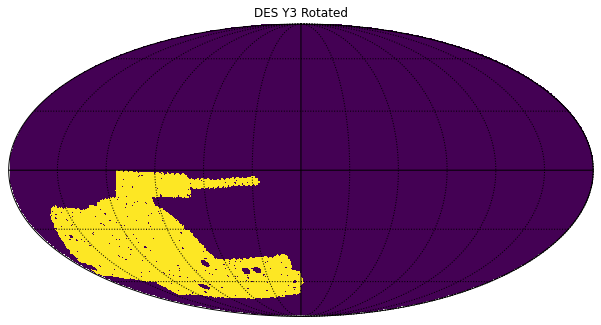

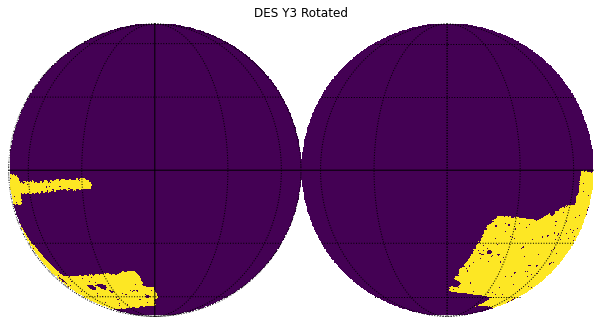

In [6]:
# these rotation angles were found by trial and error

y_rot = get_rot_y(-0.125)
# y_rot.shape = (3,3), rot_vec.shape = (n_galaxies, 3)
rot_vec = np.dot(y_rot, vec.T)

z_rot = get_rot_z(-1.22)
# z_rot.shape = (3,3), rot_vec.shape = (3, n_galaxies)
rot_vec = np.dot(z_rot, rot_vec)

rot_pix = hp.vec2pix(nside, rot_vec[0], rot_vec[1], rot_vec[2])

# plot the rotated mask
rot_mask = np.zeros(npix)
rot_mask[rot_pix] = 1
hp.mollview(rot_mask, cbar=False, title="DES Y3 Rotated")
hp.graticule()
hp.orthview(rot_mask, cbar=False, title="DES Y3 Rotated")
hp.graticule()

### HEALPix symmetry transformations
These enable a perfect one to one mapping between the pixels

In [7]:
# let's try to mirror it (up down)
def mirror_pix(pix, nside=nside, lr=False):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    if lr:
        phi = 2*np.pi - phi
    else:
        theta = np.pi - theta
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)
    # we make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    return new_pix

# now 90 degree rotations
def rotate_pix(pix, n_rot=1, nside=nside):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    phi = (phi + n_rot*np.pi/2) % (2*np.pi)
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)
    # we make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    return new_pix

In [8]:
# remove double counting from the rotated pixels
patch_0 = np.unique(rot_pix)

number of pixels included more than once is 0


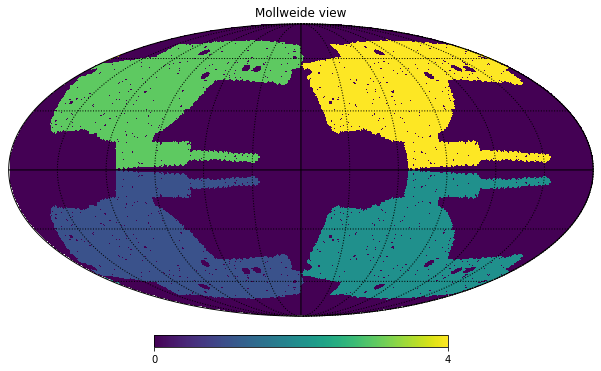

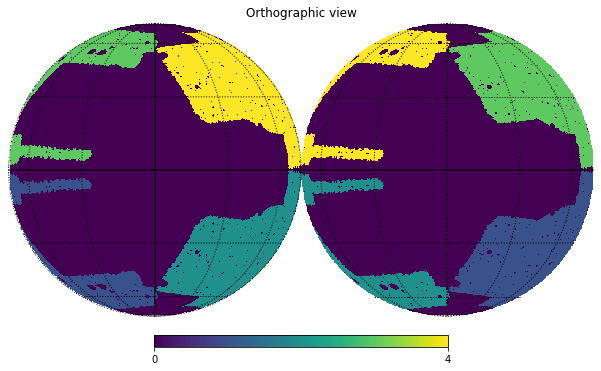

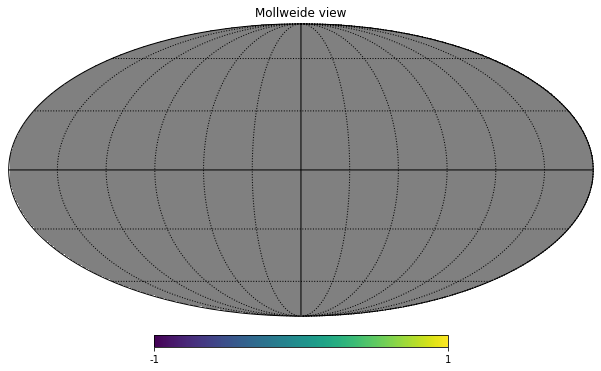

In [9]:
# mask to include all four patches (in different colors)
full_mask = np.zeros(npix)
# mask to check whether any pixel is included by more than one patch
counter_mask = np.zeros(npix)

# original patch
full_mask[patch_0] = 1
counter_mask[patch_0] += 1

patch_1 = rotate_pix(patch_0, n_rot=2)
full_mask[patch_1] = 2
counter_mask[patch_1] += 1

patch_2 = mirror_pix(patch_0, lr=False)
full_mask[patch_2] = 3
counter_mask[patch_2] += 1

patch_3 = mirror_pix(patch_0, lr=False)
patch_3 = rotate_pix(patch_3, n_rot=2)
full_mask[patch_3] = 4
counter_mask[patch_3] += 1

counter_mask = np.where(counter_mask > 1, 1, hp.UNSEEN)
assert len(counter_mask) == npix
assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
print(f"number of pixels included more than once is {np.sum(counter_mask==1)}")

# plot the full mask including the four patches
hp.mollview(full_mask)
hp.graticule()
hp.orthview(full_mask)
hp.graticule()

# plot the pixels that occur more than once
hp.mollview(counter_mask)
hp.graticule()